In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [12]:
# from google.colab import drive
# drive.mount("/content/drive/")

In [13]:
# Load the datasets
df_2023 = pd.read_csv('/content/employee-compensation-2023.csv')
df_2022 = pd.read_csv('/content/employee-compensation-2022.csv')

In [14]:
df_2021 = pd.read_csv('/content/employee-compensation-2021.csv', encoding='ISO-8859-1')
df_2020 = pd.read_csv('/content/employee-compensation-2020.csv', encoding='ISO-8859-1')
df_2019 = pd.read_csv('/content/employee-compensation-2019.csv', encoding='ISO-8859-1')
df_2018 = pd.read_csv('/content/employee-compensation-2018.csv', encoding='ISO-8859-1')
df_2017 = pd.read_csv('/content/employee-compensation-2017.csv', encoding='ISO-8859-1')

In [15]:
# Add year columns
df_2023['Year'] = 2023
df_2022['Year'] = 2022
df_2021['Year'] = 2021
df_2020['Year'] = 2020
df_2019['Year'] = 2019
df_2018['Year'] = 2018
df_2017['Year'] = 2017

In [16]:
# Rename Job Title columns
df_2023.rename(columns={'Job Title (as of 12/31/23)': 'Job Title'}, inplace=True)
df_2022.rename(columns={'Job Title (as of 12/31/22)': 'Job Title'}, inplace=True)
df_2021.rename(columns={'Job Title (as of 12/31/21)': 'Job Title'}, inplace=True)
df_2020.rename(columns={'Job Title (as of 12/31/20)': 'Job Title'}, inplace=True)
df_2019.rename(columns={'Job Title (as of 12/31/19)': 'Job Title'}, inplace=True)
df_2018.rename(columns={'Job Title (as of 12/31/18)': 'Job Title'}, inplace=True)
df_2017.rename(columns={'Job Title (as of 12/31/17)': 'Job Title'}, inplace=True)

In [17]:
def clean_and_analyze_dataframe(df):
    # Print the dimensions of the dataframe before cleaning
    dimensions = df.shape
    print(f"Number of rows: {dimensions[0]}")
    print(f"Number of columns: {dimensions[1]}")

    if 'Retirement Contributions (Normal Cost) - City Paid*' in df.columns:
        df.rename(columns={'Retirement Contributions (Normal Cost) - City Paid*': 'Retirement Contributions (Normal Cost) - City Paid'}, inplace=True)


    # Drop specified columns
    columns_to_drop = [
        'Name', 'Department', 'Sick and Vacation Payouts', 'Other Cash Compensation',
        'Defined Contribution Plan Contributions - City Paid', 'Medical Dental Vision',
        'Retirement Contributions (Normal Cost) - City Paid',
        'Long Term Disability, Life, Medicare', 'Misc Employment Related Costs'
    ]
    df.drop(columns_to_drop, axis=1, inplace=True)

    # Define the columns to clean and convert to float
    columns_to_clean = [
        'Total Cash Compensation', 'Base Pay', 'Overtime'
    ]

    # Remove commas, dollar signs, and spaces, and convert columns to float
    for column in columns_to_clean:
        df[column] = df[column].astype(str).str.replace('[\$,]', '', regex=True).str.strip()
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Verify the data type of each column
    data_types = df[columns_to_clean].dtypes
    print("Data types after cleaning:")
    print(data_types)

    # Check for missing values in the dataframe
    missing_values_count = df.isnull().sum()
    print("Missing values in each column before dropping NaNs:")
    print(missing_values_count)

    # Remove rows where 'Base Pay' is NaN or less than or equal to 0
    df_cleaned = df.dropna(subset=['Base Pay'])
    df_cleaned = df_cleaned[df_cleaned['Base Pay'] > 0]

    # Fill missing values in 'Overtime' column with 0
    df_cleaned['Overtime'].fillna(0, inplace=True)

    # Check for missing values after cleaning
    missing_values_count = df_cleaned.isnull().sum()
    print("Missing values in each column after cleaning:")
    print(missing_values_count)

    # Calculate the hourly rate and add it as a new column 'HourlyRate'
    df_cleaned['HourlyRate'] = df_cleaned['Base Pay'] / (40 * 52)

    # Count the number of rows where 'HourlyRate' is 0
    num_hourly_rate_zero = (df_cleaned['HourlyRate'] == 0).sum()
    print(f"Number of rows where HourlyRate is 0: {num_hourly_rate_zero}")

    # Calculate the hours worked as overtime and add it as a new column 'Hours Worked Overtime'
    df_cleaned['Hours Worked Overtime'] = df_cleaned['Overtime'] / df_cleaned['HourlyRate']

    # Calculate the 45th and 80th percentiles of 'Hours Worked Overtime'
    percentile_45 = df_cleaned['Hours Worked Overtime'].quantile(0.45)
    percentile_80 = df_cleaned['Hours Worked Overtime'].quantile(0.80)

    # Categorize based on the percentiles
    def categorize_stress_level(hours):
        if hours < percentile_45:
            return 'Low Stress'
        elif hours <= percentile_80:
            return 'Medium Stress'
        else:
            return 'High Stress'

    # Apply the categorization function
    df_cleaned['Stress Level'] = df_cleaned['Hours Worked Overtime'].apply(categorize_stress_level)

    # Display the counts for 'High Stress', 'Medium Stress', and 'Low Stress'
    stress_level_counts = df_cleaned['Stress Level'].value_counts()
    print("Stress Level counts:")
    print(stress_level_counts)

    # df_cleaned['Stress Index'] = (df_cleaned['Hours Worked Overtime'] / df_cleaned['Base Pay']) + df_cleaned['Hours Worked Overtime']




    return df_cleaned

In [18]:
df_2023_cleaned = clean_and_analyze_dataframe(df_2023)
df_2022_cleaned = clean_and_analyze_dataframe(df_2022)
df_2021_cleaned = clean_and_analyze_dataframe(df_2021)
df_2020_cleaned = clean_and_analyze_dataframe(df_2020)
df_2019_cleaned = clean_and_analyze_dataframe(df_2019)
df_2018_cleaned = clean_and_analyze_dataframe(df_2018)
df_2017_cleaned = clean_and_analyze_dataframe(df_2017)


Number of rows: 8646
Number of columns: 14
Data types after cleaning:
Total Cash Compensation    float64
Base Pay                   float64
Overtime                   float64
dtype: object
Missing values in each column before dropping NaNs:
Job Title                     0
Total Cash Compensation       0
Base Pay                     65
Overtime                   3831
Year                          0
dtype: int64
Missing values in each column after cleaning:
Job Title                  0
Total Cash Compensation    0
Base Pay                   0
Overtime                   0
Year                       0
dtype: int64
Number of rows where HourlyRate is 0: 0
Stress Level counts:
Stress Level
Low Stress       3855
Medium Stress    2998
High Stress      1713
Name: count, dtype: int64
Number of rows: 8475
Number of columns: 14
Data types after cleaning:
Total Cash Compensation    float64
Base Pay                   float64
Overtime                   float64
dtype: object
Missing values in each colu

<ipython-input-17-881b09ccefba>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Overtime'].fillna(0, inplace=True)
<ipython-input-17-881b09ccefba>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

Stress Level counts:
Stress Level
Medium Stress    6478
High Stress      1620
Name: count, dtype: int64
Number of rows: 8173
Number of columns: 14
Data types after cleaning:
Total Cash Compensation    float64
Base Pay                   float64
Overtime                   float64
dtype: object
Missing values in each column before dropping NaNs:
Job Title                     0
Total Cash Compensation       0
Base Pay                     58
Overtime                   3870
Year                          0
dtype: int64
Missing values in each column after cleaning:
Job Title                  0
Total Cash Compensation    0
Base Pay                   0
Overtime                   0
Year                       0
dtype: int64
Number of rows where HourlyRate is 0: 0
Stress Level counts:
Stress Level
Medium Stress    6486
High Stress      1622
Low Stress          1
Name: count, dtype: int64
Number of rows: 8554
Number of columns: 14
Data types after cleaning:
Total Cash Compensation    float64
Base Pa

<ipython-input-17-881b09ccefba>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Overtime'].fillna(0, inplace=True)
<ipython-input-17-881b09ccefba>:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df_combined = pd.concat([df_2023_cleaned, df_2022_cleaned, df_2021_cleaned, df_2020_cleaned, df_2019_cleaned, df_2018_cleaned, df_2017_cleaned], ignore_index=True)


In [21]:
df_combined.shape

(58006, 8)

In [22]:
missing_values_count = df_combined.isnull().sum()

# Display the result
print(missing_values_count)

Job Title                  0
Total Cash Compensation    0
Base Pay                   0
Overtime                   0
Year                       0
HourlyRate                 0
Hours Worked Overtime      0
Stress Level               0
dtype: int64


In [23]:
job_title_counts = df_combined['Job Title'].value_counts()
print("Unique job titles and their counts:")
print(job_title_counts)

Unique job titles and their counts:
Job Title
Police Officer                    6098
Recreation Leader PT              5439
Fire Fighter                      1643
School Crossing Guard PT          1643
Fire Engineer                     1595
                                  ... 
Reg Wastewater Fac Gen Mgr U         1
Council ComnRel Director U PT        1
Literacy Program Specialist PT       1
Assist City Auditor U                1
Real Estate Specialist               1
Name: count, Length: 637, dtype: int64


In [24]:
df_combined.head()

,Job Title,Total Cash Compensation,Base Pay,Overtime,Year,HourlyRate,Hours Worked Overtime,Stress Level
0,Fire Captain,620986.55,180574.29,436373.06,2023,86.814563,5026.496102,High Stress
1,Fire Captain,505127.13,180574.29,309358.34,2023,86.814563,3563.438334,High Stress
2,Police Lieutenant,457417.50,201148.00,218841.40,2023,96.705769,2262.961163,High Stress
3,Fire Engineer,453006.39,157370.85,291596.34,2023,75.659063,3854.083442,High Stress
4,Fire Engineer,446067.98,157370.85,287852.25,2023,75.659063,3804.597103,High Stress


In [25]:
# Remove rows where 'Job Title' ends with ' U'
df_combined = df_combined[~df_combined['Job Title'].str.contains(r' U| U ', na=False)]

In [26]:
df_combined.head()

,Job Title,Total Cash Compensation,Base Pay,Overtime,Year,HourlyRate,Hours Worked Overtime,Stress Level
0,Fire Captain,620986.55,180574.29,436373.06,2023,86.814563,5026.496102,High Stress
1,Fire Captain,505127.13,180574.29,309358.34,2023,86.814563,3563.438334,High Stress
2,Police Lieutenant,457417.50,201148.00,218841.40,2023,96.705769,2262.961163,High Stress
3,Fire Engineer,453006.39,157370.85,291596.34,2023,75.659063,3854.083442,High Stress
4,Fire Engineer,446067.98,157370.85,287852.25,2023,75.659063,3804.597103,High Stress


In [27]:
from google.colab import files

df_combined.to_csv('df_combined.csv', index = False)
files.download('df_combined.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
job_title_counts = df_combined['Job Title'].value_counts()
# job_titles_more_than_100 = job_title_counts[job_title_counts > 100]
# print(job_titles_more_than_100)

job_titles_more_than_100 = job_title_counts[job_title_counts > 100].index
df_filtered = df_combined[df_combined['Job Title'].isin(job_titles_more_than_100)]


df_filtered.to_csv('df_filtered.csv', index = False)
files.download('df_filtered.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
df_filtered

df_filtered.shape


,Job Title,Total Cash Compensation,Base Pay,Overtime,Year,HourlyRate,Hours Worked Overtime,Stress Level,Job Title Encoded
0,Fire Captain,620986.55,180574.29,436373.06,2023,86.814563,5026.496102,High Stress,26
1,Fire Captain,505127.13,180574.29,309358.34,2023,86.814563,3563.438334,High Stress,26
2,Police Lieutenant,457417.50,201148.00,218841.40,2023,96.705769,2262.961163,High Stress,57
3,Fire Engineer,453006.39,157370.85,291596.34,2023,75.659063,3854.083442,High Stress,27
4,Fire Engineer,446067.98,157370.85,287852.25,2023,75.659063,3804.597103,High Stress,27


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Create sample dataset
# data = df_filtered

data = pd.read_csv('./df_filtered.csv')# remove this



# Display the first few rows of the dataset
print("Dataset Preview:")
display(data.head())

class CompensationPredictor:
    def __init__(self):
        self.comp_model = RandomForestRegressor(random_state=42)
        self.stress_model = RandomForestClassifier(random_state=42)
        self.scaler = StandardScaler()
        self.job_title_encoder = LabelEncoder()
        self.stress_encoder = LabelEncoder()

    def prepare_data(self, data):
        """Prepare the dataset for training"""
        # Encode Job Title as a numerical feature
        data['Job Title Encoded'] = self.job_title_encoder.fit_transform(data['Job Title'])

        # Create features (Job Title and Year)
        features = data[['Job Title Encoded', 'Year']].copy()

        # Create targets
        comp_target = data['Total Cash Compensation']
        stress_target = self.stress_encoder.fit_transform(data['Stress Level'])

        # Scale features (not really necessary in this case, but for consistency)
        scaled_features = self.scaler.fit_transform(features)

        return scaled_features, comp_target, stress_target

    def train(self, data):
        """Train both compensation and stress level models"""
        # Prepare data
        X, y_comp, y_stress = self.prepare_data(data)

        # Split data
        X_train, X_test, y_comp_train, y_comp_test, y_stress_train, y_stress_test = train_test_split(
            X, y_comp, y_stress, test_size=0.2, random_state=42
        )

        # Train compensation model
        self.comp_model.fit(X_train, y_comp_train)
        comp_pred = self.comp_model.predict(X_test)
        comp_rmse = np.sqrt(mean_squared_error(y_comp_test, comp_pred))

        # Train stress level model
        self.stress_model.fit(X_train, y_stress_train)
        stress_pred = self.stress_model.predict(X_test)
        stress_report = classification_report(y_stress_test, stress_pred)

        return {
            'compensation_rmse': comp_rmse,
            'stress_classification_report': stress_report
        }

    def predict(self, job_title, year):
        """Make predictions for new data based on job title and year"""
        # Encode the job title input
        job_title_encoded = self.job_title_encoder.transform([job_title])[0]

        # Prepare input data
        input_data = np.array([[job_title_encoded, year]])
        scaled_input = self.scaler.transform(input_data)

        # Make predictions
        predicted_comp = self.comp_model.predict(scaled_input)[0]
        stress_pred = self.stress_model.predict(scaled_input)[0]
        stress_label = self.stress_encoder.inverse_transform([stress_pred])[0]

        return {
            'predicted_compensation': predicted_comp,
            'predicted_stress_level': stress_label
        }

# Initialize and train the model
predictor = CompensationPredictor()
metrics = predictor.train(data)

print("\nModel Performance Metrics:")
print(f"Compensation RMSE: ${metrics['compensation_rmse']:.2f}")
print("\nStress Level Classification Report:")
print(metrics['stress_classification_report'])


Dataset Preview:


,Job Title,Total Cash Compensation,Base Pay,Overtime,Year,HourlyRate,Hours Worked Overtime,Stress Level,Job Title Encoded
0,Fire Captain,620986.55,180574.29,436373.06,2023,86.814563,5026.496102,High Stress,26
1,Fire Captain,505127.13,180574.29,309358.34,2023,86.814563,3563.438334,High Stress,26
2,Police Lieutenant,457417.50,201148.00,218841.40,2023,96.705769,2262.961163,High Stress,57
3,Fire Engineer,453006.39,157370.85,291596.34,2023,75.659063,3854.083442,High Stress,27
4,Fire Engineer,446067.98,157370.85,287852.25,2023,75.659063,3804.597103,High Stress,27



Model Performance Metrics:
Compensation RMSE: $31366.09

Stress Level Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      2047
           1       0.73      0.86      0.79      1416
           2       0.87      0.72      0.79      4888

    accuracy                           0.77      8351
   macro avg       0.75      0.80      0.76      8351
weighted avg       0.79      0.77      0.77      8351



In [3]:

# Make a prediction for 2024
prediction = predictor.predict(
    job_title='Police Lieutenant',
    year=2025
)

print("\nPrediction for 2024:")
print(f"Predicted Compensation: ${prediction['predicted_compensation']:.2f}")
print(f"Predicted Stress Level: {prediction['predicted_stress_level']}")

# Create a function to make interactive predictions
def make_prediction():
    job_title = input("Enter job title (e.g., Fire Captain): ")
    year = int(input("Enter year (e.g., 2024): "))

    prediction = predictor.predict(job_title, year)
    print(f"\nPredicted Compensation: ${prediction['predicted_compensation']:.2f}")
    print(f"Predicted Stress Level: {prediction['predicted_stress_level']}")

# Uncomment the following line to make interactive predictions
# make_prediction()



Prediction for 2024:
Predicted Compensation: $299992.76
Predicted Stress Level: High Stress


/Users/mac/Desktop/cmpe255_project/env/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [4]:
import joblib

# Save the RandomForest models to .pkl files
joblib.dump(predictor.comp_model, 'compensation_model.pkl')
joblib.dump(predictor.stress_model, 'stress_model.pkl')
joblib.dump(predictor.job_title_encoder, 'job_title_encoder.pkl')
joblib.dump(predictor.stress_encoder, 'stress_encoder.pkl')
joblib.dump(predictor.scaler, 'scaler.pkl')

print("Models saved successfully.")


Models saved successfully.


In [5]:
# hyperparameter tuning; ref => https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

from pprint import pprint

rf_comp = predictor.comp_model
rf_stress = predictor.stress_model
print('Parameters currently in use for compensation predictor :\n')
pprint(rf_comp.get_params())
print('Parameters currently in use for stress classifier :\n')
pprint(rf_stress.get_params())

Parameters currently in use for compensation predictor :

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
Parameters currently in use for stress classifier :

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [6]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np

class TunedCompensationPredictor(CompensationPredictor):
    def __init__(self):
        super().__init__()
        
        # Define parameter distributions for RandomizedSearchCV
        self.comp_param_dist = {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [10, 20, 30, 40, 50, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        
        self.stress_param_dist = {
            'n_estimators': [100, 200, 300, 400, 500],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [10, 20, 30, 40, 50, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False],
            'class_weight': ['balanced', 'balanced_subsample', None]
        }

    def tune_models(self, data, n_iter=100, cv=5):
        """Tune both models using RandomizedSearchCV"""
        # Prepare data
        X, y_comp, y_stress = self.prepare_data(data)
        
        # Tune compensation model
        comp_random = RandomizedSearchCV(
            estimator=RandomForestRegressor(random_state=42),
            param_distributions=self.comp_param_dist,
            n_iter=n_iter,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        comp_random.fit(X, y_comp)
        
        # Tune stress model
        stress_random = RandomizedSearchCV(
            estimator=RandomForestClassifier(random_state=42),
            param_distributions=self.stress_param_dist,
            n_iter=n_iter,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            random_state=42
        )
        stress_random.fit(X, y_stress)
        
        # Update models with best parameters
        self.comp_model = comp_random.best_estimator_
        self.stress_model = stress_random.best_estimator_
        
        return {
            'compensation_best_params': comp_random.best_params_,
            'compensation_best_score': comp_random.best_score_,
            'stress_best_params': stress_random.best_params_,
            'stress_best_score': stress_random.best_score_
        }
    
    def evaluate_with_cross_validation(self, data, cv=5):
        """Evaluate models using cross-validation"""
        X, y_comp, y_stress = self.prepare_data(data)
        
        # Cross-validate compensation model
        comp_scores = cross_val_score(
            self.comp_model, 
            X, 
            y_comp, 
            cv=cv, 
            scoring='neg_root_mean_squared_error'
        )
        
        # Cross-validate stress model
        stress_scores = cross_val_score(
            self.stress_model,
            X,
            y_stress,
            cv=cv,
            scoring='accuracy'
        )
        
        return {
            'compensation_cv_rmse': -comp_scores.mean(),
            'compensation_cv_rmse_std': comp_scores.std(),
            'stress_cv_accuracy': stress_scores.mean(),
            'stress_cv_accuracy_std': stress_scores.std()
        }

# Usage example:
tuned_predictor = TunedCompensationPredictor()

# Tune the models (this may take some time)
tuning_results = tuned_predictor.tune_models(data, n_iter=50, cv=5)

# Get cross-validation results
cv_results = tuned_predictor.evaluate_with_cross_validation(data, cv=5)

# Print results
print("\nTuning Results:")
print("\nCompensation Model:")
print(f"Best parameters: {tuning_results['compensation_best_params']}")
print(f"Best score: {tuning_results['compensation_best_score']:.2f}")

print("\nStress Model:")
print(f"Best parameters: {tuning_results['stress_best_params']}")
print(f"Best score: {tuning_results['stress_best_score']:.2f}")

print("\nCross-validation Results:")
print(f"\nCompensation RMSE: ${cv_results['compensation_cv_rmse']:.2f} (+/- ${cv_results['compensation_cv_rmse_std']*2:.2f})")
print(f"Stress Classification Accuracy: {cv_results['stress_cv_accuracy']:.2f} (+/- {cv_results['stress_cv_accuracy_std']*2:.2f})")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tuning Results:

Compensation Model:
Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best score: 0.43

Stress Model:
Best parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 10, 'class_weight': 'balanced_subsample', 'bootstrap': False}
Best score: 0.52

Cross-validation Results:

Compensation RMSE: $51920.33 (+/- $34509.97)
Stress Classification Accuracy: 0.52 (+/- 0.36)


Compensation Model Comparison:
Original RMSE: $31,366.09
Tuned RMSE: $31,439.86
Original R²: 0.830
Tuned R²: 0.829

Stress Level Classification Comparison:
Original Accuracy: 0.769
Tuned Accuracy: 0.752

Original Model Stress Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      2047
           1       0.73      0.86      0.79      1416
           2       0.87      0.72      0.79      4888

    accuracy                           0.77      8351
   macro avg       0.75      0.80      0.76      8351
weighted avg       0.79      0.77      0.77      8351


Tuned Model Stress Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.90      0.72      2047
           1       0.67      0.93      0.78      1416
           2       0.93      0.64      0.76      4888

    accuracy                           0.75      8351
   macro avg       0.74      0.82      0.75      8351
w

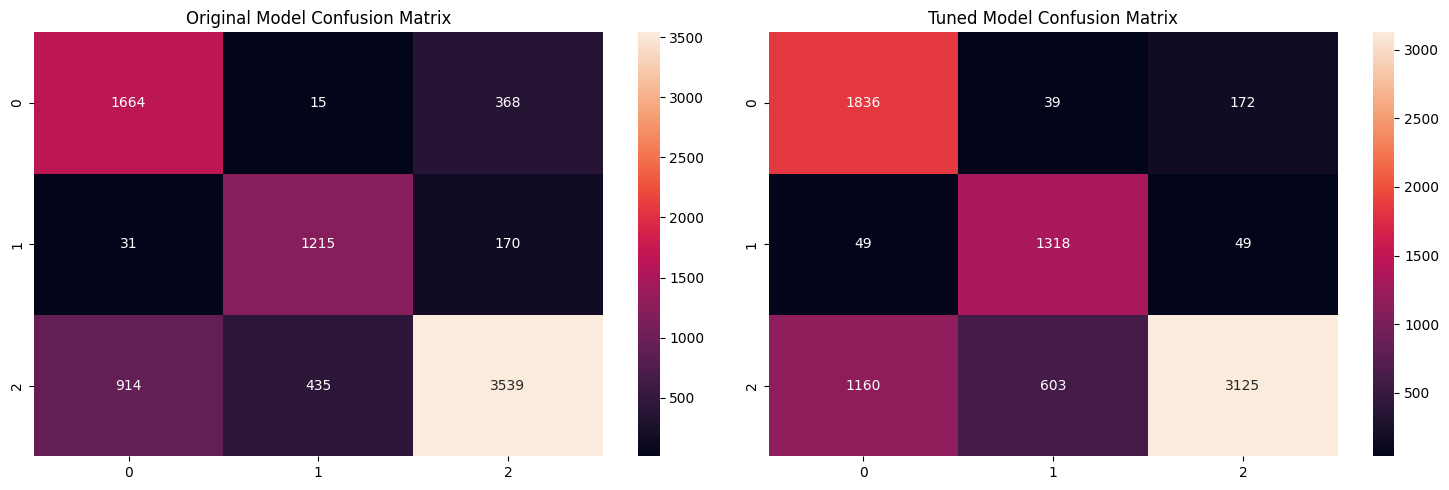

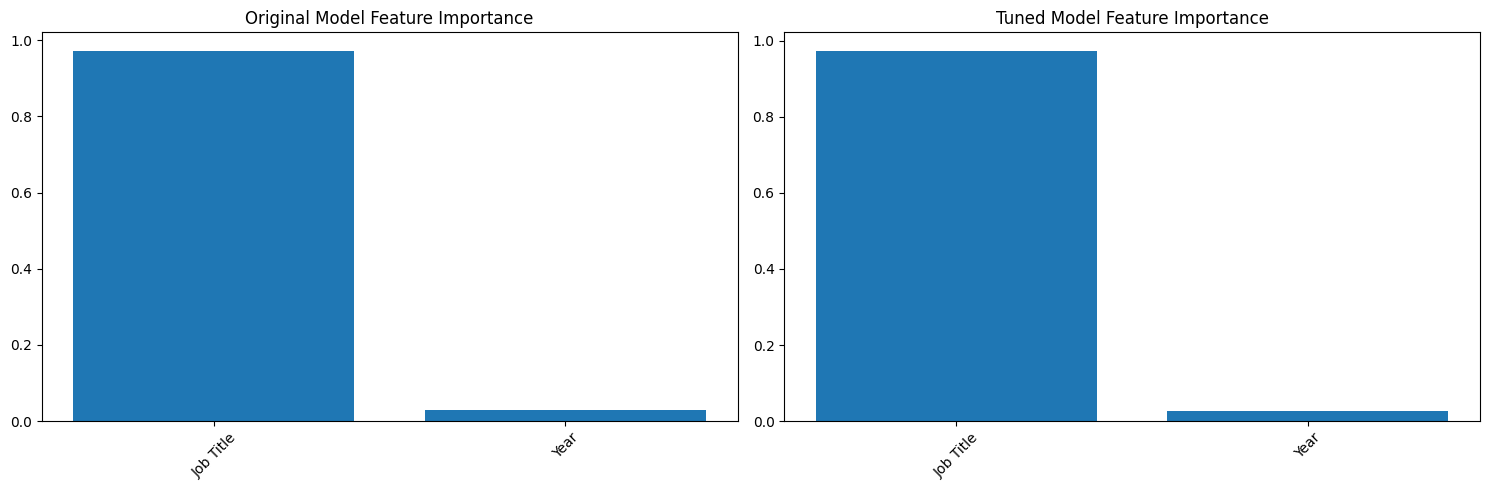

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def compare_models(original_predictor, tuned_predictor, data, test_size=0.2):
    """Compare performance of original and tuned models"""
    
    # Prepare data
    X, y_comp, y_stress = original_predictor.prepare_data(data)
    
    # Split data
    X_train, X_test, y_comp_train, y_comp_test, y_stress_train, y_stress_test = train_test_split(
        X, y_comp, y_stress, test_size=test_size, random_state=42
    )
    
    # Train and predict with original model
    original_predictor.comp_model.fit(X_train, y_comp_train)
    original_predictor.stress_model.fit(X_train, y_stress_train)
    
    orig_comp_pred = original_predictor.comp_model.predict(X_test)
    orig_stress_pred = original_predictor.stress_model.predict(X_test)
    
    # Train and predict with tuned model
    tuned_predictor.comp_model.fit(X_train, y_comp_train)
    tuned_predictor.stress_model.fit(X_train, y_stress_train)
    
    tuned_comp_pred = tuned_predictor.comp_model.predict(X_test)
    tuned_stress_pred = tuned_predictor.stress_model.predict(X_test)
    
    # Calculate metrics
    results = {
        'original': {
            'compensation': {
                'rmse': np.sqrt(mean_squared_error(y_comp_test, orig_comp_pred)),
                'r2': r2_score(y_comp_test, orig_comp_pred)
            },
            'stress': {
                'accuracy': accuracy_score(y_stress_test, orig_stress_pred),
                'report': classification_report(y_stress_test, orig_stress_pred),
                'confusion': confusion_matrix(y_stress_test, orig_stress_pred)
            }
        },
        'tuned': {
            'compensation': {
                'rmse': np.sqrt(mean_squared_error(y_comp_test, tuned_comp_pred)),
                'r2': r2_score(y_comp_test, tuned_comp_pred)
            },
            'stress': {
                'accuracy': accuracy_score(y_stress_test, tuned_stress_pred),
                'report': classification_report(y_stress_test, tuned_stress_pred),
                'confusion': confusion_matrix(y_stress_test, tuned_stress_pred)
            }
        }
    }
    
    # Print comparison
    print("Compensation Model Comparison:")
    print(f"Original RMSE: ${results['original']['compensation']['rmse']:,.2f}")
    print(f"Tuned RMSE: ${results['tuned']['compensation']['rmse']:,.2f}")
    print(f"Original R²: {results['original']['compensation']['r2']:.3f}")
    print(f"Tuned R²: {results['tuned']['compensation']['r2']:.3f}")
    
    print("\nStress Level Classification Comparison:")
    print(f"Original Accuracy: {results['original']['stress']['accuracy']:.3f}")
    print(f"Tuned Accuracy: {results['tuned']['stress']['accuracy']:.3f}")
    
    print("\nOriginal Model Stress Classification Report:")
    print(results['original']['stress']['report'])
    
    print("\nTuned Model Stress Classification Report:")
    print(results['tuned']['stress']['report'])
    
    # Visualize confusion matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.heatmap(results['original']['stress']['confusion'], annot=True, fmt='d', ax=ax1)
    ax1.set_title('Original Model Confusion Matrix')
    
    sns.heatmap(results['tuned']['stress']['confusion'], annot=True, fmt='d', ax=ax2)
    ax2.set_title('Tuned Model Confusion Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Compare the models
original_predictor = CompensationPredictor()
results = compare_models(original_predictor, tuned_predictor, data)

# Feature importance comparison
def plot_feature_importance_comparison(original_predictor, tuned_predictor, feature_names):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Original model importance
    importances_orig = original_predictor.comp_model.feature_importances_
    indices_orig = np.argsort(importances_orig)[::-1]
    
    ax1.bar(range(len(importances_orig)), importances_orig[indices_orig])
    ax1.set_title('Original Model Feature Importance')
    ax1.set_xticks(range(len(importances_orig)))
    ax1.set_xticklabels([feature_names[i] for i in indices_orig], rotation=45)
    
    # Tuned model importance
    importances_tuned = tuned_predictor.comp_model.feature_importances_
    indices_tuned = np.argsort(importances_tuned)[::-1]
    
    ax2.bar(range(len(importances_tuned)), importances_tuned[indices_tuned])
    ax2.set_title('Tuned Model Feature Importance')
    ax2.set_xticks(range(len(importances_tuned)))
    ax2.set_xticklabels([feature_names[i] for i in indices_tuned], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Plot feature importance comparison
feature_names = ['Job Title', 'Year']
plot_feature_importance_comparison(original_predictor, tuned_predictor, feature_names)